# Data

In [1]:
from torchvision.datasets import MNIST
from torchvision import transforms
import torch
from torch import nn
import numpy as np
import matplotlib.pylab as plt

torch.manual_seed(0)

if torch.cuda.is_available():
  device = torch.device('cuda:0')
else:
  device = torch.device('cpu')

print('Using torch version {}'.format(torch.__version__))
print('Using {} device'.format(device))
  
# Training dataset
train_loader = torch.utils.data.DataLoader(
    MNIST(root='.', train=True, download=True,
          transform=transforms.ToTensor()),
    batch_size=100, shuffle=True, pin_memory=True)
# Test dataset
test_loader = torch.utils.data.DataLoader(
    MNIST(root='.', train=False, transform=transforms.ToTensor()),
    batch_size=100, shuffle=True, pin_memory=True)

Using torch version 2.1.0
Using cpu device


In [2]:
from itertools import chain

def train_model(loss, model, batch_size=10, num_epochs=3, learning_rate=1e-3):
    gd = torch.optim.Adam(
        chain(*[x.parameters() for x in model
                if (isinstance(x, nn.Module) or isinstance(x, nn.Parameter))]),
        lr=learning_rate)
    train_losses = []
    test_results = []
    for _ in range(num_epochs):
        for i, (batch, _) in enumerate(train_loader):
            total = len(train_loader)
            gd.zero_grad()
            batch = batch.view(-1, D).to(device)
            loss_value, _ = loss(batch, *model)
            loss_value.backward()
            train_losses.append(loss_value.item())
            if (i + 1) % 10 == 0:
                print('\rTrain loss:', train_losses[-1],
                      'Batch', i + 1, 'of', total, ' ' * 10, end='', flush=True)
            gd.step()
        test_loss = 0.
        for i, (batch, _) in enumerate(test_loader):
            batch = batch.view(-1, D).to(device)
            batch_loss, _ = loss(batch, *model)
            test_loss += (batch_loss - test_loss) / (i + 1)
        print('\nTest loss after an epoch: {}'.format(test_loss))

# VAE

VAE on MNIST. In particular $p_\theta(x \mid z) = \mathtt{Bernoulli}(\mathtt{Decoder}(z))$ and $q_\phi(z \mid x) = \mathtt{Normal}(\mathtt{EncoderMu}(x), \exp(\mathtt{EncoderSigma}(x)))$ and $p(z) = \mathtt{Normal}(\mathbf{0}, \mathbf{I})$

### Z dimension - 2

In [3]:
# d: Size of latent space
# nh: Number of hidden units in the encoder/decoder network
# D: Dimension of the observation data
d, nh, D = 2, 100, 28 * 28

In [26]:
# enc: A network that maps from R^D to R^(2 * d)
enc = nn.Sequential(
    nn.Linear(D, nh),
    nn.ReLU(),
    nn.Linear(nh, nh),
    nn.ReLU(),
    nn.Linear(nh, 2 * d)) # note that the final layer outputs real values

# enc: A network that maps from R^d to R^D
dec = nn.Sequential(
    nn.Linear(d, nh),
    nn.ReLU(),
    nn.Linear(nh, nh),
    nn.ReLU(),
    nn.Linear(nh, D)).to(device) 

In [27]:
# Move the network to GPU if available
enc = enc.to(device)
dec = dec.to(device)

## ELBO

`loss_vae` function, which is the negative ELBO **averaged over minibatch samples**, see the docstring for detailed description.

In [6]:
from torch.distributions import Normal, Bernoulli, Independent

def loss_vae(x, encoder, decoder):
    """
    Input:
    x: a tensor of shape (batch_size, D), normalized to range [0, 1]
    encoder: a network that takes in x and returns a tensor of shape (batch_size, 2 * d),
        where d is the latent space size
    decoder: a network that takes in tensor of (batch_size, d) and
        returns a real-value tensor of shape (batch_size, D)
    Return:
    1. the **avergave** value of negative ELBO across the minibatch x
    2. and the output of the decoder
    """
    eps = 1e-9 #For numerical stability

    batch_size, D = tuple(x.shape) #D is dimension of x
    phi_params = encoder(x) #phi_params = (mu_phi, sigma^2_phi) params for q_phi(z|x) ~ posterior probability
    phi_params = torch.reshape(phi_params, (batch_size, 2, -1))
    mu_phi = phi_params[:,0,:]
    log_var_phi = phi_params[:,1,:]
    sigma_phi = torch.exp(log_var_phi * 0.5) #exp to make sure variance is positive (diagonal of covariance matrix is variance of X and var(x)>=0)
    _, _, d = tuple(phi_params.shape)
    prior_z = Normal(torch.zeros(d), torch.ones(d), validate_args=False) #prob_(z) ~ multivariate normal (assumed)
    sample_prior_z = prior_z.rsample(torch.Size([batch_size])) # Sample Z
    z = mu_phi + sample_prior_z * sigma_phi #Sample from q(z|x) ~ N(mu_phi, (sigma_phi**2) * I)
    
    decoder_output = decoder(z)
    output_activation = nn.Sigmoid()
    probs = output_activation(decoder_output)
    distr_x_given_z = Bernoulli(probs =probs, validate_args=False)
    distr_x_i_given_z = Independent(distr_x_given_z, 1)

    rec_loss = torch.sum(distr_x_given_z.log_prob(x+eps), dim=1).mean()
    kl_loss = -0.5 * torch.sum(1 + log_var_phi - mu_phi.pow(2) - log_var_phi.exp(), dim=1)

    loss = -rec_loss + kl_loss.mean()

    return loss, decoder_output

In [7]:
train_model(loss_vae, model=[enc, dec], num_epochs=10)

Train loss: 180.9342041015625 Batch 600 of 600            
Test loss after an epoch: 176.6195831298828
Train loss: 160.94239807128906 Batch 600 of 600           
Test loss after an epoch: 165.8651123046875
Train loss: 164.95391845703125 Batch 600 of 600           
Test loss after an epoch: 161.88829040527344
Train loss: 165.95828247070312 Batch 600 of 600           
Test loss after an epoch: 159.1084747314453
Train loss: 150.68148803710938 Batch 600 of 600           160.15933227539062 Batch 100 of 600           
Test loss after an epoch: 155.3767547607422
Train loss: 165.20504760742188 Batch 600 of 600           
Test loss after an epoch: 153.5839385986328
Train loss: 156.5542755126953 Batch 600 of 600             154.13275146484375 Batch 290 of 600           
Test loss after an epoch: 152.32810974121094
Train loss: 149.21066284179688 Batch 600 of 600            147.93057250976562 Batch 260 of 600           
Test loss after an epoch: 151.81983947753906
Train loss: 149.31211853027344 Ba

## Sample generation

Plot 50 generated samples using the `plot_samples` function below.

Note: generated samples need to be converted from torch tensor to numpy array before feeding into the function.

In [9]:
def plot_samples(samples, h=5, w=10):
    fig, axes = plt.subplots(nrows=h,
                             ncols=w,
                             figsize=(int(1.4 * w), int(1.4 * h)),
                             subplot_kw={'xticks': [], 'yticks': []})
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(samples[i], cmap='gray')

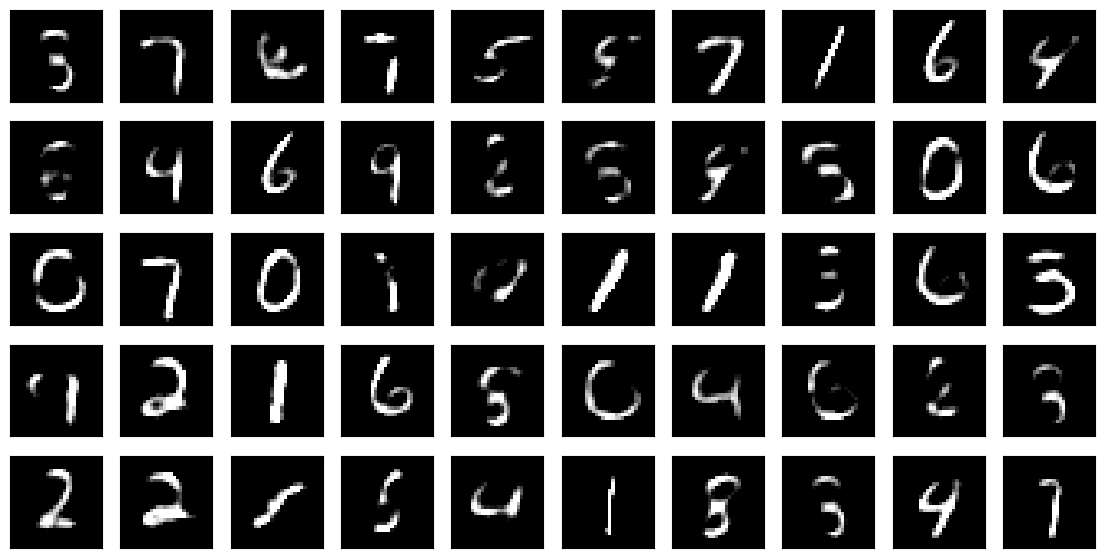

In [10]:
with torch.no_grad():
    z = torch.randn(50, d).to(device)
    samples_x = dec(z).clamp(0, 1).reshape(50, 28, 28)
plot_samples(samples_x)

## Latent space inspection

Now, with a batch of data from the test sample, the learned encoder is used to acquire a latent representation (denoted by Z) for these data.

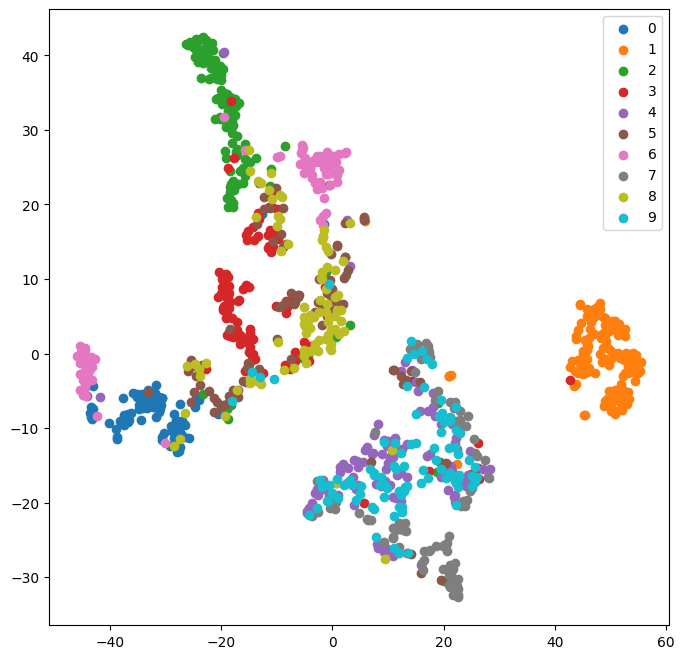

In [11]:
from sklearn.manifold import TSNE

with torch.no_grad():
    batch = (test_loader.dataset.data[:1000].float() / 255.)
    batch = batch.view(-1, D).to(device)
    labels = test_loader.dataset.targets[:1000].numpy()

    Z = enc(batch)
    
embeddings = TSNE(n_components=2).fit_transform(Z)
plt.figure(figsize=(8, 8))
for k in range(10):
    embeddings_for_k = embeddings[labels == k]
    plt.scatter(embeddings_for_k[:, 0], embeddings_for_k[:, 1],
                label='{}'.format(k))
plt.legend()

### Visualization for uniform sampling (Z-dim=2)

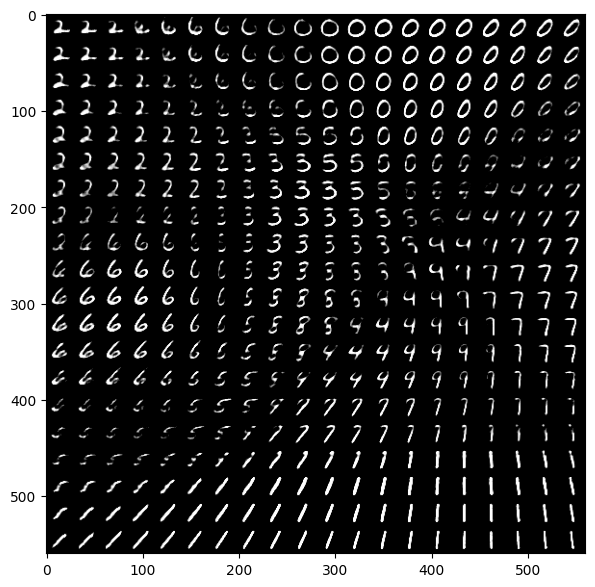

In [12]:
image_size = 28
values = np.arange(-2, 2, 0.2)
xx, yy = np.meshgrid(values, values)
input_holder = np.zeros((1, 2))

container = np.zeros((image_size * len(values), image_size * len(values)))

with torch.no_grad():
    for row in range(xx.shape[0]):
        for col in range(xx.shape[1]):
            input_holder = np.array([[xx[row, col], yy[row, col]]])
            output = dec(torch.tensor(input_holder, dtype=torch.float32)).clamp(0, 1).reshape((image_size,image_size))
            container[row * image_size: (row + 1) * image_size, col * image_size: (col + 1) * image_size] = np.squeeze(output)

plt.figure(figsize=(50,7))
plt.imshow(container, cmap='gray')

### SLERP Interpolation in latent space

In this visualization, we can see how the numbers transition to their nearest ones when interpolated by slerp. We can see the graduate translation. This gives us an intuition about how digits are interpreted by the VAE.

In [13]:
def slerp(Z1, Z2, t):
    omega = torch.acos(torch.sum(Z1 / torch.norm(Z1) * (Z2 / torch.norm(Z2))))
    so = torch.sin(omega)
    return torch.sin((1 - t) * omega) / so * Z1 + torch.sin(t * omega) / so * Z2

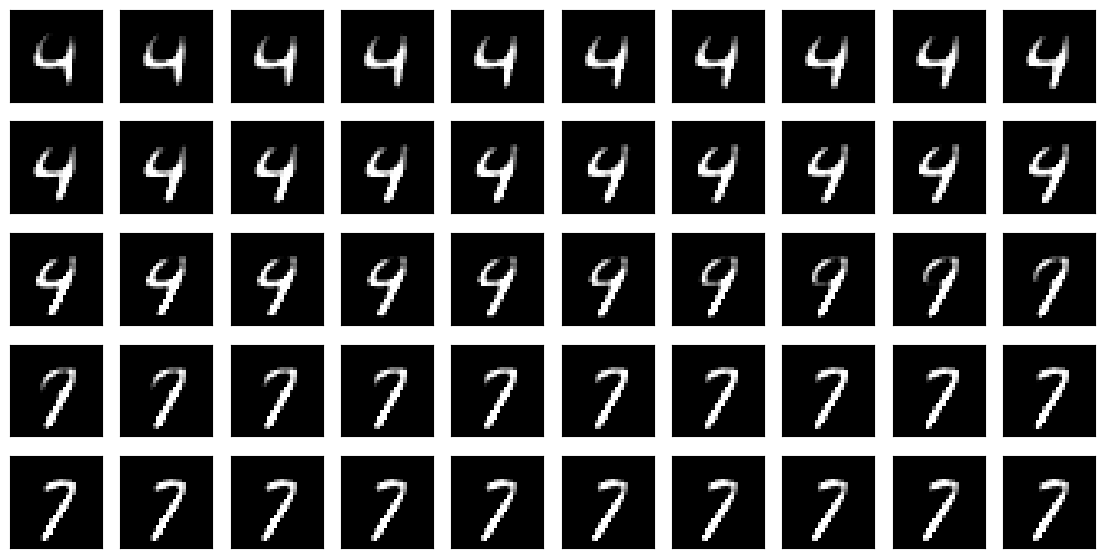

In [15]:
with torch.no_grad():
    z1 = torch.rand(1, d).to(device)
    z2 = torch.rand(1, d).to(device)
    embeddings = []
    num_interpolation_steps = 50
    for i in range(num_interpolation_steps):
        alpha = i / (num_interpolation_steps - 1)
        interpolated_embedding = slerp(z1, z2, alpha)
        embeddings.append(interpolated_embedding)

    # print(np.array(embeddings).shape)    
    samples_x = dec(torch.tensor((np.array(embeddings)))).clamp(0, 1).reshape(50, 28, 28)
plot_samples(samples_x)

### Linear Interpolation

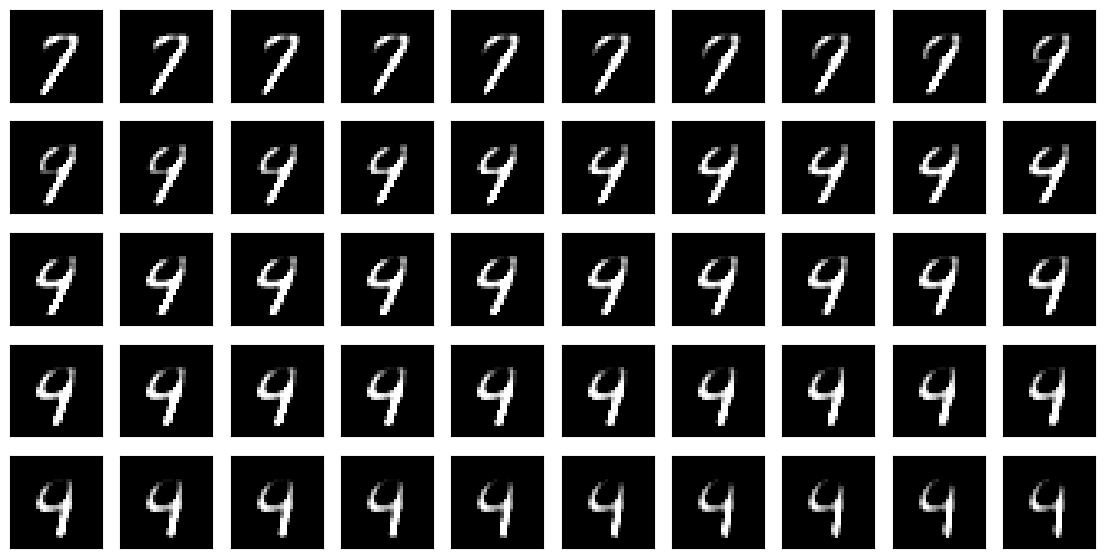

In [16]:
with torch.no_grad():
    z1 = torch.rand(1, d).to(device)
    z2 = torch.rand(1, d).to(device)
    embeddings = []
    num_interpolation_steps = 50
    for i in range(num_interpolation_steps):
        alpha = i / (num_interpolation_steps - 1)
        interpolated_embedding = alpha * z1 + (1 - alpha) * z2 
        embeddings.append(interpolated_embedding)

    # print(np.array(embeddings).shape)    
    samples_x = dec(torch.tensor((np.array(embeddings)))).clamp(0, 1).reshape(50, 28, 28)
plot_samples(samples_x)

### Z-dimension = 32

In [25]:
# d: Size of latent space
# nh: Number of hidden units in the encoder/decoder network
# D: Dimension of the observation data
d, nh, D = 32, 100, 28 * 28

**Run the encoder, decoder configuration cell again before running the below cells**

In [28]:
train_model(loss_vae, model=[enc, dec], num_epochs=10)

Train loss: 179.92657470703125 Batch 600 of 600           
Test loss after an epoch: 169.0474395751953
Train loss: 140.09324645996094 Batch 600 of 600            158.35423278808594 Batch 190 of 600           
Test loss after an epoch: 140.0558624267578
Train loss: 130.40267944335938 Batch 600 of 600            128.48739624023438 Batch 380 of 600           
Test loss after an epoch: 128.41175842285156
Train loss: 125.54589080810547 Batch 600 of 600           
Test loss after an epoch: 122.95372772216797
Train loss: 123.87594604492188 Batch 600 of 600           
Test loss after an epoch: 119.91673278808594
Train loss: 117.1161880493164 Batch 600 of 600            
Test loss after an epoch: 117.55451965332031
Train loss: 116.56790161132812 Batch 600 of 600           
Test loss after an epoch: 115.70071411132812
Train loss: 117.58617401123047 Batch 600 of 600           
Test loss after an epoch: 114.72844696044922
Train loss: 114.364990234375 Batch 600 of 600             
Test loss after a

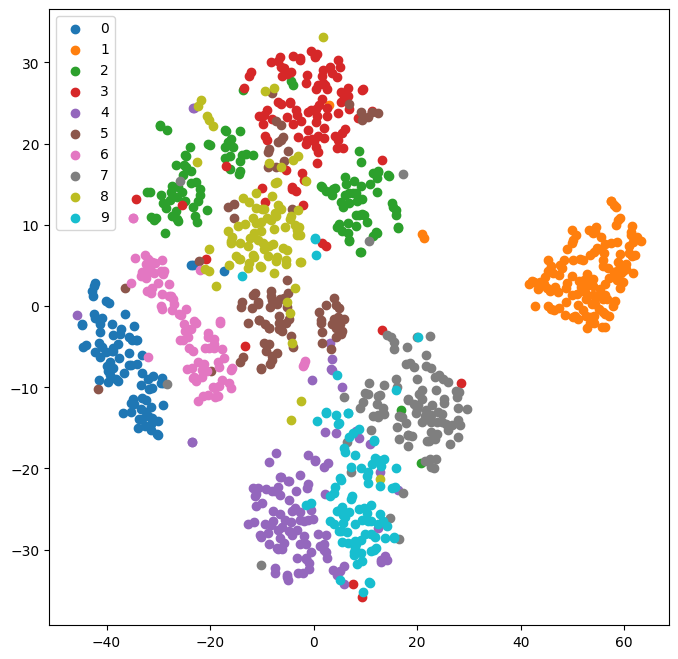

In [30]:
from sklearn.manifold import TSNE

with torch.no_grad():
    batch = (test_loader.dataset.data[:1000].float() / 255.)
    batch = batch.view(-1, D).to(device)
    labels = test_loader.dataset.targets[:1000].numpy()
  
    Z = enc(batch)
    
embeddings = TSNE(n_components=2).fit_transform(Z)
plt.figure(figsize=(8, 8))
for k in range(10):
    embeddings_for_k = embeddings[labels == k]
    plt.scatter(embeddings_for_k[:, 0], embeddings_for_k[:, 1],
                label='{}'.format(k))
plt.legend()

**Z - Dimension = 32**
```
In the t-SNE embeddings, clusters of data points corresponding to different digit classes can be observed. 1 almost doesn't have any overlap with other digits. Likewise, 8 has the most overlap with other digits. 4 and 9 overlap to some extent. 3 and 8 have a significant overlap out of all digits and very close to each other. 5 and 8 also overlap well to some extent. 0, 1, 2, 6 and 7 are very well distinguished and have very limited overlap with other digits.
```

# Latent Normalization flow

In this, MNIST samples are generated using "latent normalization flow". To be more specific, we will not directly fit a flow on the MNIST images, instead, use the flow to approximate the marginal variational posterior acquired from VAE, i.e. $q_\phi(z) = \sum_x q_\phi(z \mid x)p(x)$. In simpler language:
- First collect a bunch of samples from $q_\phi(z \mid x)$ using all $x$ from the training set
- Then fit a flow on these samples.
- Lastly feed samples generated from the flow into the decoder to generate MNIST samples.

## RealNVP Model

In [31]:
class RealNVP(nn.Module):
    def __init__(self, nets, nett, mask, prior):
        super(RealNVP, self).__init__()
        
        # Create a flow
        # nets:  a function that returns a PyTorch neural network, e.g., nn.Sequential, s = nets(), s: dim(X) -> dim(X)
        # nett:  a function that returns a PyTorch neural network, e.g., nn.Sequential, t = nett(), t: dim(X) -> dim(X)
        # mask:  a torch.Tensor of size #number_of_coupling_layers x #dim(X)
        # prior: an object from torch.distributions e.g., torch.distributions.MultivariateNormal
        
        self.prior = prior
        self.mask = nn.Parameter(mask, requires_grad=False)
        self.t = torch.nn.ModuleList([nett() for _ in range(len(masks))])
        self.s = torch.nn.ModuleList([nets() for _ in range(len(masks))])
        
    def g(self, z):
        # Compute and return g(z) = x, 
        #    where self.mask[i], self.t[i], self.s[i] define a i-th masked coupling layer   
        # z: a torch.Tensor of shape batchSize x 1 x dim(X)
        # return x: a torch.Tensor of shape batchSize x 1 x dim(X)
        x = z
        for i in range(len(self.t)):
            s = self.s[i](x * self.mask[i])
            t = self.t[i](x * self.mask[i])
            x = x * torch.exp(s) + t
        return x

    def f(self, x):
        # Compute f(x) = z and log_det_Jakobian of f, 
        #    where self.mask[i], self.t[i], self.s[i] define a i-th masked coupling layer   
        # x: a torch.Tensor, of shape batchSize x dim(X), is a datapoint
        # return z: a torch.Tensor of shape batchSize x dim(X), a hidden representations
        # return log_det_J: a torch.Tensor of len batchSize
        log_det_J, z = x.new_zeros(x.shape[0]), x
        for i in reversed(range(len(self.t))):
            s = self.s[i](z * self.mask[i])
            t = self.t[i](z * self.mask[i])
            z = (z - t) * torch.exp(-s)
            log_det_J -= torch.sum(s, dim=1)
        return z, log_det_J
    
    def log_prob(self, x):
        # Compute and return log p(x)
        # using the change of variable formula and log_det_J computed by f
        # return logp: torch.Tensor of len batchSize
        z, logp = self.f(x)
        
        return self.prior.log_prob(z) + logp
        
        
    def sample(self, batchSize): 
        # Draw and return batchSize samples from flow using implementation of g
        # return x: torch.Tensor of shape batchSize x 1 x dim(X)
        
        return self.g(self.prior.sample_n(batchSize))

**Note**

Using your learned encoder from VAE to acquire **one** sample of $z$ for **each** $x$ in MNIST's training data. We use
```
train_loader.dataset.data.float() / 255.
```
to get the full training set. Samples are stored in `mnist_embeddings`

In [32]:
with torch.autograd.no_grad():
    batch = (train_loader.dataset.data.float() / 255.)
    batch = batch.view(-1, 28*28).to(device)

    # Acquire one sample of Z from VAE encoder
    batch_size, D = tuple(batch.shape)
    phi_params = enc(batch) #phi_params = (mu_phi, log_var_phi) params for q_phi(z|x) ~ posterior probability
    phi_params = torch.reshape(phi_params, (batch_size, 2, -1))
    mu_phi = phi_params[:,0,:]
    log_var_phi = phi_params[:,1,:]
    sigma_phi = torch.exp(log_var_phi * 0.5) #exp to make sure variance is positive (diagonal of covariance matrix is variance of X and var(x)>=0)
    
    mnist_embeddings = mu_phi + sigma_phi

assert mnist_embeddings.shape == (60000, 32)

## Z-dimension = 32

In [33]:
# Specify the hyperparameters
D = 32
nets = lambda: nn.Sequential(nn.Linear(D, 128), nn.LeakyReLU(), nn.Linear(128, 128), nn.LeakyReLU(), nn.Linear(128, D), nn.Tanh())
nett = lambda: nn.Sequential(nn.Linear(D, 128), nn.LeakyReLU(), nn.Linear(128, 128), nn.LeakyReLU(), nn.Linear(128, D))
masks = torch.from_numpy(np.array(
    [[0] * (D // 2) + [1] * (D // 2), [1] * (D // 2) + [0] * (D // 2)] * 3
).astype(np.float32))
prior = torch.distributions.MultivariateNormal(torch.zeros(D).to(device), torch.eye(D).to(device))

flow = RealNVP(nets, nett, masks, prior)
flow.to(device)

# Fire up the training !
batch_size = 1000
optimizer = torch.optim.Adam([p for p in flow.parameters() if p.requires_grad==True], lr=1e-4)
for t in range(5000):  
    mini_batch_idx = torch.randint(0, 60000, size=(batch_size,)).to(device)
    loss = -flow.log_prob(mnist_embeddings[mini_batch_idx]).mean()
    
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    
    if t % 500 == 0:
        print('iter %s:' % t, 'loss = %.3f' % loss)

iter 0: loss = 46.233
iter 500: loss = -93.768
iter 1000: loss = -113.367
iter 1500: loss = -125.305
iter 2000: loss = -129.427
iter 2500: loss = -137.246
iter 3000: loss = -140.986
iter 3500: loss = -143.512
iter 4000: loss = -142.589
iter 4500: loss = -145.735


Now, generate 100 samples from the flow, and feed the generated samples to the decoder of the VAE acquired previously, and run the plot_samples command.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/distributions/distribution.py:179: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn(


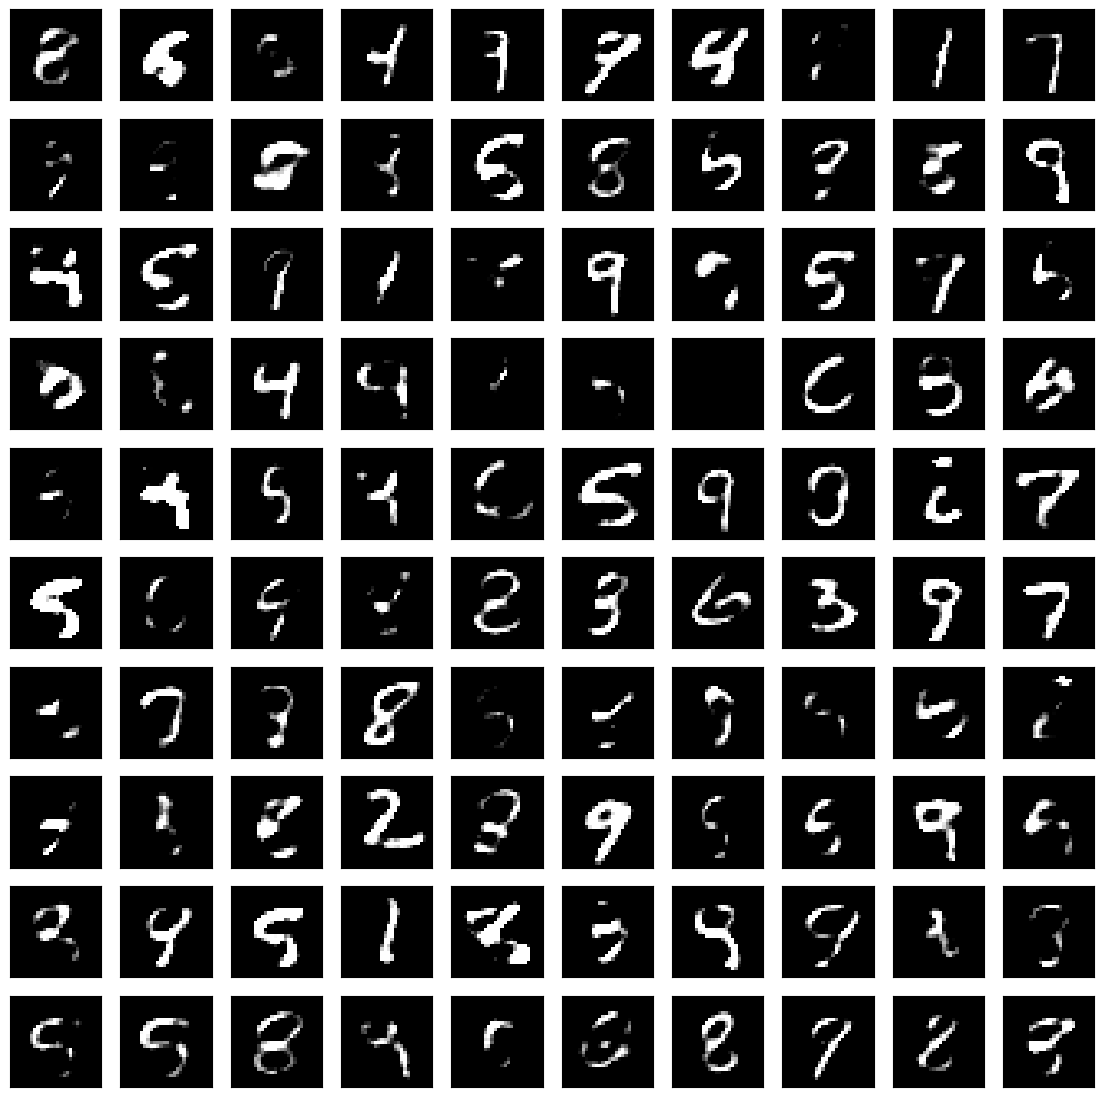

In [34]:
with torch.no_grad():
    samples = dec(flow.sample(100)).clamp(0, 1)
    
plot_samples(samples.reshape(-1, 28, 28), 10, 10)

**Compared to directly fitting a flow on MNIST, potential advantage and disadvantage of fitting a flow on the "latent" space compared to fitting the flow on the originial pixel space**

```
Advantages:
1. Dimensionality reduction and better understanding of the features in latent space.
2. Modeling the latent space directly allows for better separation of the factors of variation in the data

Disadvantages:
1. Loss of information happens when we move to latent space. But for flow models , the number of computations increase and the training time and model parameters also increase significantly.
```